# **Significant Earthquakes, 1965-2016**

Date, time, and location of all earthquakes with magnitude of 5.5 or higher

## **About the Dataset**

This dataset includes a record of the date, time, location, depth, magnitude, and source of every earthquake with a reported magnitude 5.5 or higher since 1965.

In [21]:
from google.colab import drive, userdata
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import the libraries

In [22]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

In [23]:
# Setting the environment variables
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')

In [24]:
# Download dataset from Kaggle
!pip install kaggle
!kaggle datasets download usgs/earthquake-database
!unzip earthquake-database.zip

earthquake-database.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  earthquake-database.zip
replace database.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: database.csv            


In [25]:
# read the data
earthquakes = pd.read_csv("/content/database.csv")

# set seed for reproducibility
np.random.seed(0)

## Check the data type of our date column


In [26]:
earthquakes['Date'].dtype

dtype('O')

## Convert our date columns to datetime

Some entries follow a different datetime format compared to rest.

In [27]:
earthquakes[3378:3383]

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
3378,1975-02-23T02:58:41.000Z,1975-02-23T02:58:41.000Z,8.017,124.075,Earthquake,623.0,NaN,NaN,5.6,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000A09,US,US,US,Reviewed
3379,02/23/1975,03:53:36,-21.727,-71.356,Earthquake,33.0,NaN,NaN,5.6,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000A0A,US,US,US,Reviewed
3380,02/23/1975,07:34:11,-10.879,166.667,Earthquake,33.0,NaN,NaN,5.5,MS,...,NaN,NaN,NaN,NaN,NaN,USP0000A0C,US,US,US,Reviewed
3381,02/25/1975,05:20:05,-7.388,149.798,Earthquake,33.0,NaN,NaN,5.5,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000A12,US,US,US,Reviewed
3382,02/26/1975,04:48:55,85.047,97.969,Earthquake,33.0,NaN,NaN,5.6,MS,...,NaN,NaN,NaN,NaN,NaN,USP0000A1H,US,US,US,Reviewed


This does appear to be an issue with data entry: ideally, all entries in the column have the same format.  We can get an idea of how widespread this issue is by checking the length of each entry in the "Date" column.

In [28]:
date_lengths = earthquakes.Date.str.len()
date_lengths.value_counts()

10    23409
24        3
Name: Date, dtype: int64

Looks like there are two more rows that has a date in a different format.

In [29]:
indices = np.where([date_lengths == 24])[1]
print('Indices with corrupted data:', indices)
earthquakes.loc[indices]

Indices with corrupted data: [ 3378  7512 20650]


,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
3378,1975-02-23T02:58:41.000Z,1975-02-23T02:58:41.000Z,8.017,124.075,Earthquake,623.0,NaN,NaN,5.6,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000A09,US,US,US,Reviewed
7512,1985-04-28T02:53:41.530Z,1985-04-28T02:53:41.530Z,-32.998,-71.766,Earthquake,33.0,NaN,NaN,5.6,MW,...,NaN,NaN,NaN,NaN,1.30,USP0002E81,US,US,HRV,Reviewed
20650,2011-03-13T02:23:34.520Z,2011-03-13T02:23:34.520Z,36.344,142.344,Earthquake,10.1,13.9,289.0,5.8,MWC,...,NaN,32.3,NaN,NaN,1.06,USP000HWQP,US,US,GCMT,Reviewed


In [30]:
from datetime import date,datetime
import pandas as pd
from pandas.api.types import is_datetime64_any_dtype,is_object_dtype


def parse_dates(date_obj_col: pd.core.series, dateonly: bool, date_format: str, sep='/'):
    '''
    parses pandas object into uniform string format and converts into pandas datetime64 format

    Arguments:
    date_obj_col: pandas series - column of dtype object which need to be converted to datetime64.
    dateonly: bool - if True, then pandas datetime64 object will be further parsed to return only date.
                     if False, then time part will not be excluded in the final result.
    date_format: str - can be '%m%d%y' or '%d%m%y' or '%y%m%d or '%m%d%Y' or '%d%m%Y' or '%Y%m%d'
                  where 'Y' represents 4 digit year and 'y' represents 2 digit year.
    sep: str - default value= '/'. Can be '-', '.'


    Returns:
    Only date component of pandas datetime64 if dateonly=True in the given format.
    pandas series of dtype datetime64 if dateonly=False in the given format.
    '''
    date_col_copy = date_obj_col.copy()
    if type(date_col_copy)==pd.core.series.Series and is_object_dtype(date_col_copy):
        if dateonly is True:
            if((date_col_copy.str.len()>10).any()):
                indices = date_col_copy.str.len()>10
                if date_col_copy[indices].size > 1:
                  date_col_copy[indices] = date_col_copy[indices].str.replace(r'[T\s][0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{3}Z', '', regex=True)
                  date_col_copy[indices] = date_col_copy[indices].str.replace(r'[T\s][0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{3}', '', regex=True)
                  date_col_copy[indices] = date_col_copy[indices].str.replace(r'[T\s][0-9]{2}:[0-9]{2}:[0-9]{2}', '', regex=True)
                  date_col_copy[indices] = date_col_copy[indices].str.replace(r'[T\s][0-9]{2}[0-9]{2}[0-9]{2}', '', regex=True)
                  date_col_copy[indices] = date_col_copy[indices].str.replace(r'[T\s][0-9]{2}[0-9]{2}[0-9]{2}.[0-9]{3}Z', '', regex=True)
                  date_col_copy[indices] = date_col_copy[indices].str.replace(r'[T\s][0-9]{2}[0-9]{2}[0-9]{2}.[0-9]{3}', '', regex=True)

                  date_col_copy[indices] = date_col_copy[indices].str.replace(r'[T\s][0-9]{2}:[0-9]{2}:[0-9]{2} [AaPp][Mm]', '')
                  date_col_copy[indices] = date_col_copy[indices].str.replace(r'[T\s][0-9]{2}:[0-9]{2} [AaPp][Mm]', '')
                elif date_col_copy[indices].size == 1:
                  date_col_copy[indices] = date_col_copy[indices].replace(r'[T\s][0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{3}Z', '', regex=True)
                  date_col_copy[indices] = date_col_copy[indices].replace(r'[T\s][0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{3}', '', regex=True)
                  date_col_copy[indices] = date_col_copy[indices].replace(r'[T\s][0-9]{2}:[0-9]{2}:[0-9]{2}', '', regex=True)
                  date_col_copy[indices] = date_col_copy[indices].replace(r'[T\s][0-9]{2}[0-9]{2}[0-9]{2}', '', regex=True)
                  date_col_copy[indices] = date_col_copy[indices].replace(r'[T\s][0-9]{2}[0-9]{2}[0-9]{2}.[0-9]{3}Z', '', regex=True)
                  date_col_copy[indices] = date_col_copy[indices].replace(r'[T\s][0-9]{2}[0-9]{2}[0-9]{2}.[0-9]{3}', '', regex=True)

                  date_col_copy[indices] = date_col_copy[indices].replace(r'[T\s][0-9]{2}:[0-9]{2}:[0-9]{2} [AaPp][Mm]', '')
                  date_col_copy[indices] = date_col_copy[indices].replace(r'[T\s][0-9]{2}:[0-9]{2} [AaPp][Mm]', '')



        if (date_col_copy.str.find('/')!=-1).any() or (date_col_copy.str.find('-')!=-1).any() or (date_col_copy.str.find('.')!=-1).any():
            if sep == '/':
                if (date_col_copy.str.find('-')!=-1).any():
                    date_col_copy = date_col_copy.str.replace('-', '/')
                if (date_col_copy.str.find('.')!=-1).any():
                    date_col_copy = date_col_copy.str.replace('.', '/')
            elif sep == '-':
                if (date_col_copy.str.find('/')!=-1).any():
                    date_col_copy = date_col_copy.str.replace('/', '-')
                if (date_col_copy.str.find('.')!=-1).any():
                    date_col_copy = date_col_copy.str.replace('.', '-')
            elif sep == '.':
                if (date_col_copy.str.find('/')!=-1).any():
                    date_col_copy = date_col_copy.str.replace('/', '.')
                if (date_col_copy.str.find('-')!=-1).any():
                    date_col_copy = date_col_copy.str.replace('-', '.')
        else:
            # To handle the case of no separator in dates like DDMMYY or DDMMYYYY or MMDDYY or MMDDYYYY
            # TO DO
            pass


       # To try converting dtype to pandas datetime64 object using pd.to_datetime
        try:
            if(is_datetime64_any_dtype(date_col_copy)):
                return date_col_copy
            else:
                date_col_copy_final = pd.to_datetime(date_col_copy, format=date_format[:2]+sep+date_format[2:4]+sep+date_format[4:6],errors='coerce')
                if(date_col_copy_final.isna().any()):
                    nat_condition = date_col_copy_final.isna()
                    nat_indices = date_col_copy_final[nat_condition].index.tolist()
                    date_col_nat = date_col_copy[nat_indices]
                    split_date = []
                    for key,val in dict(date_col_nat).items():
                      if sep in ['', None] or sep not in val:
                            raise ValueError(f'{val} at index {key} is not in any of the specified datetime format')
                      else:
                            # To try to rearrange the NaT dates as per date_format
                            split_date = val.split(sep)
                            if date_format == '%m%d%y' and sep not in ['', None]:
                                if ((len(split_date[0])==2) and int(split_date[0]) in range(0,int(str(date.today().year)[2:])+1)) or \
                              (len(split_date[0])==4) and int(split_date[0]) in range(1945, int(str(date.today().year))+1):
                                    if(len(split_date[1])==2 and int(split_date[1]) in range(1,13)):
                                        if(len(split_date[2])==2 and int(split_date[2])in range(1,32)):
                                            date_col_copy_final[nat_indices]=split_date[1]+sep+split_date[2]+sep+(split_date[0] if len(split_date[0])==2 else split_date[0][2:])
                                elif (len(split_date[0]==2) and int(split_date[0]) in range(1,13)):
                                    if(len(split_date[1])==2 and int(split_date[1]) in range(1,32)):
                                        if(len(split_date[2])==2 and int(split_date[2]) in range(0,int(str(date.today().year)[2:])+1)) or \
                                     (len(split_date[2])==4) and int(split_date[0]) in range(1945, int(str(date.today().year))+1):
                                            date_col_copy_final[nat_indices]=split_date[0]+sep+split_date[1]+sep+(split_date[2] if len(split_date[2])==2 else split_date[2][2:])
                                elif (len(split_date[0])==2) and int(split_date[0]) in range(1,32):
                                    if (len(split_date[1])==2) and split_date[1] in range(1,13):
                                        if ((len(split_date[2])==2) and int(split_date[2]) in range(0, int(str(date.today().year)[2:])+1)) or \
                                     (len(split_date[2])==4) and int(split_date[2]) in range(1945, int(str(date.today().year))+1):
                                            date_col_copy_final[nat_indices] = split_date[1]+sep+split_date[0]+sep+(split_date[2] if len(split_date[2])==2 else split_date[2][2:])
                            elif date_format == '%m%d%Y' and sep not in ['', None]:
                                if ((len(split_date[0])==2) and int(split_date[0]) in range(0,int(str(date.today().year)[2:])+1)) or \
                              (len(split_date[0])==4) and int(split_date[0]) in range(1945, int(str(date.today().year))+1):
                                    if(len(split_date[1])==2 and int(split_date[1]) in range(1,13)):
                                        if(len(split_date[2])==2 and int(split_date[2])in range(1,32)):
                                            date_col_copy_final[nat_indices]=split_date[1]+sep+split_date[2]+sep+ \
                                         (split_date[0] if len(split_date[0])==4 else ('19' if int(split_date[0])>45 else '20')+split_date[0])
                                elif (len(split_date[0]==2) and int(split_date[0]) in range(1,13)):
                                    if(len(split_date[1])==2 and int(split_date[1]) in range(1,32)):
                                        if(len(split_date[2])==2 and int(split_date[2]) in range(0,int(str(date.today().year)[2:])+1)) or \
                                     (len(split_date[2])==4) and int(split_date[0]) in range(1945, int(str(date.today().year))+1):
                                            date_col_copy_final[nat_indices]=split_date[0]+sep+split_date[1]+sep+ \
                                         (split_date[2] if len(split_date[2])==4 else ('19' if int(split_date[2])>45 else '20')+split_date[2])
                                elif (len(split_date[0])==2) and int(split_date[0]) in range(1,32):
                                    if (len(split_date[1])==2) and split_date[1] in range(1,13):
                                        if ((len(split_date[2])==2) and int(split_date[2]) in range(0, int(str(date.today().year)[2:])+1)) or \
                                     (len(split_date[2])==4) and int(split_date[2]) in range(1945, int(str(date.today().year))+1):
                                            date_col_copy_final[nat_indices] = split_date[1]+sep+split_date[0]+sep+ \
                                         (split_date[2] if len(split_date[2])==4 else ('19' if int(split_date[2])>45 else '20')+split_date[2])
                            elif date_format == '%d%m%y' and sep not in ['', None]:
                                if ((len(split_date[0])==2) and int(split_date[0]) in range(0,int(str(date.today().year)[2:])+1)) or \
                             (len(split_date[0])==4) and int(split_date[0]) in range(1945, int(str(date.today().year))+1):
                                    if(len(split_date[1])==2 and int(split_date[1]) in range(1,13)):
                                        if(len(split_date[2])==2 and int(split_date[2])in range(1,32)):
                                            date_col_copy_final[nat_indices]=split_date[2]+sep+split_date[1]+sep+(split_date[0] if len(split_date[0])==2 else split_date[0][2:])
                                elif (len(split_date[0]==2) and int(split_date[0]) in range(1,13)):
                                    if(len(split_date[1])==2 and int(split_date[1]) in range(1,32)):
                                        if(len(split_date[2])==2 and int(split_date[2]) in range(0,int(str(date.today().year)[2:])+1)) or \
                                     (len(split_date[2])==4) and int(split_date[0]) in range(1945, int(str(date.today().year))+1):
                                            date_col_copy_final[nat_indices]=split_date[1]+sep+split_date[0]+sep+(split_date[2] if len(split_date[2])==2 else split_date[2][2:])
                                elif (len(split_date[0])==2) and int(split_date[0]) in range(1,32):
                                    if (len(split_date[1])==2) and split_date[1] in range(1,13):
                                        if ((len(split_date[2])==2) and int(split_date[2]) in range(0, int(str(date.today().year)[2:])+1)) or \
                                     (len(split_date[2])==4) and int(split_date[2]) in range(1945, int(str(date.today().year))+1):
                                            date_col_copy_final[nat_indices] = split_date[0]+sep+split_date[1]+sep+(split_date[2] if len(split_date[2])==2 else split_date[2][2:])
                            elif date_format == '%d%m%Y' and sep not in ['', None]:
                                if ((len(split_date[0])==2) and int(split_date[0]) in range(0,int(str(date.today().year)[2:])+1)) or \
                             (len(split_date[0])==4) and int(split_date[0]) in range(1945, int(str(date.today().year))+1):
                                    if(len(split_date[1])==2 and int(split_date[1]) in range(1,13)):
                                        if(len(split_date[2])==2 and int(split_date[2])in range(1,32)):
                                            date_col_copy_final[nat_indices]=split_date[2]+sep+split_date[1]+sep+ \
                                         (split_date[0] if len(split_date[0])==4 else ('19' if int(split_date[0])>45 else '20')+split_date[0])
                                elif (len(split_date[0]==2) and int(split_date[0]) in range(1,13)):
                                    if(len(split_date[1])==2 and int(split_date[1]) in range(1,32)):
                                        if(len(split_date[2])==2 and int(split_date[2]) in range(0,int(str(date.today().year)[2:])+1)) or \
                                     (len(split_date[2])==4) and int(split_date[0]) in range(1945, int(str(date.today().year))+1):
                                            date_col_copy_final[nat_indices]=split_date[1]+sep+split_date[0]+sep+ \
                                         (split_date[2] if len(split_date[2])==4 else ('19' if int(split_date[2])>45 else '20')+split_date[2])
                                elif (len(split_date[0])==2) and int(split_date[0]) in range(1,32):
                                    if (len(split_date[1])==2) and split_date[1] in range(1,13):
                                        if ((len(split_date[2])==2) and int(split_date[2]) in range(0, int(str(date.today().year)[2:])+1)) or \
                                     (len(split_date[2])==4) and int(split_date[2]) in range(1945, int(str(date.today().year))+1):
                                            date_col_copy_final[nat_indices] = split_date[1]+sep+split_date[0]+sep+ \
                                         (split_date[2] if len(split_date[2])==4 else ('19' if int(split_date[2])>45 else '20')+split_date[2])
                            elif date_format == '%y%m%d' and sep not in ['', None]:
                                if ((len(split_date[0])==2) and int(split_date[0]) in range(0,int(str(date.today().year)[2:])+1)) or \
                             (len(split_date[0])==4) and int(split_date[0]) in range(1945, int(str(date.today().year))+1):
                                    if(len(split_date[1])==2 and int(split_date[1]) in range(1,13)):
                                        if(len(split_date[2])==2 and int(split_date[2])in range(1,32)):
                                            date_col_copy_final[nat_indices]=(split_date[0] if len(split_date[0])==2 else split_date[0][2:])+sep+split_date[1]+sep+split_date[2]
                                elif (len(split_date[0]==2) and int(split_date[0]) in range(1,13)):
                                    if(len(split_date[1])==2 and int(split_date[1]) in range(1,32)):
                                        if(len(split_date[2])==2 and int(split_date[2]) in range(0,int(str(date.today().year)[2:])+1)) or \
                                     (len(split_date[2])==4) and int(split_date[0]) in range(1945, int(str(date.today().year))+1):
                                            date_col_copy_final[nat_indices]=(split_date[2] if len(split_date[2])==2 else split_date[2][2:])+sep+split_date[0]+sep+split_date[1]
                                elif (len(split_date[0])==2) and int(split_date[0]) in range(1,32):
                                    if (len(split_date[1])==2) and split_date[1] in range(1,13):
                                        if ((len(split_date[2])==2) and int(split_date[2]) in range(0, int(str(date.today().year)[2:])+1)) or \
                                     (len(split_date[2])==4) and int(split_date[2]) in range(1945, int(str(date.today().year))+1):
                                            date_col_copy_final[nat_indices] = (split_date[2] if len(split_date[2])==2 else split_date[2][2:])+sep+split_date[1]+sep+split_date[0]
                            elif date_format == '%Y%m%d' and sep not in ['', None]:
                                if ((len(split_date[0])==2) and int(split_date[0]) in range(0,int(str(date.today().year)[2:])+1)) or \
                             (len(split_date[0])==4) and int(split_date[0]) in range(1945, int(str(date.today().year))+1):
                                    if(len(split_date[1])==2 and int(split_date[1]) in range(1,13)):
                                        if(len(split_date[2])==2 and int(split_date[2])in range(1,32)):
                                            date_col_copy_final[nat_indices]=(split_date[0] if len(split_date[0])==4 else ('19' if int(split_date[0])>45 else '20')+
                                         split_date[0])+sep+split_date[1]+sep+split_date[2]
                                elif (len(split_date[0]==2) and int(split_date[0]) in range(1,13)):
                                    if(len(split_date[1])==2 and int(split_date[1]) in range(1,32)):
                                        if(len(split_date[2])==2 and int(split_date[2]) in range(0,int(str(date.today().year)[2:])+1)) or \
                                     (len(split_date[2])==4) and int(split_date[0]) in range(1945, int(str(date.today().year))+1):
                                            date_col_copy_final[nat_indices]=(split_date[2] if len(split_date[2])==4 else ('19' if int(split_date[2])>45 else '20')+
                                         split_date[2])+sep+split_date[0]+sep+split_date[1]
                                elif (len(split_date[0])==2) and int(split_date[0]) in range(1,32):
                                    if (len(split_date[1])==2) and split_date[1] in range(1,13):
                                        if ((len(split_date[2])==2) and int(split_date[2]) in range(0, int(str(date.today().year)[2:])+1)) or \
                                     (len(split_date[2])==4) and int(split_date[2]) in range(1945, int(str(date.today().year))+1):
                                            date_col_copy_final[nat_indices] = (split_date[2] if len(split_date[2])==4 else ('19' if int(split_date[2])>45 else '20')+split_date[2])+ \
                                         sep+split_date[1]+sep+split_date[0]
                    date_col_copy_final[nat_indices] = pd.to_datetime(date_col_copy_final[nat_indices],format=date_format[:2]+sep+date_format[2:4]+sep+date_format[4:6])
                return date_col_copy_final
        except ValueError as v:
            print(v)
    else:
        print('date_obj_col should be of type pandas.core.series.Series')


earthquakes.loc[:,'date_parsed'] = parse_dates(date_obj_col=earthquakes.loc[:,'Date'],dateonly=True,date_format='%m%d%Y')


<ipython-input-30-b1b0ade23b8f>:36: FutureWarning: The default value of regex will change from True to False in a future version.
  date_col_copy[indices] = date_col_copy[indices].str.replace(r'[T\s][0-9]{2}:[0-9]{2}:[0-9]{2} [AaPp][Mm]', '')
<ipython-input-30-b1b0ade23b8f>:37: FutureWarning: The default value of regex will change from True to False in a future version.
  date_col_copy[indices] = date_col_copy[indices].str.replace(r'[T\s][0-9]{2}:[0-9]{2} [AaPp][Mm]', '')


In [31]:
earthquakes['date_parsed'].head()

0   1965-01-02
1   1965-01-04
2   1965-01-05
3   1965-01-08
4   1965-01-09
Name: date_parsed, dtype: datetime64[ns]

## Select the day of the month

Create a Pandas Series `day_of_month_earthquakes` containing the day of the month from the "date_parsed" column.

In [32]:
# try to get the day of the month from the date column
day_of_month_earthquakes = earthquakes.loc[:,'date_parsed'].dt.day

## Plot the day of the month to check the date parsing

Plot the days of the month from earthquake dataset.

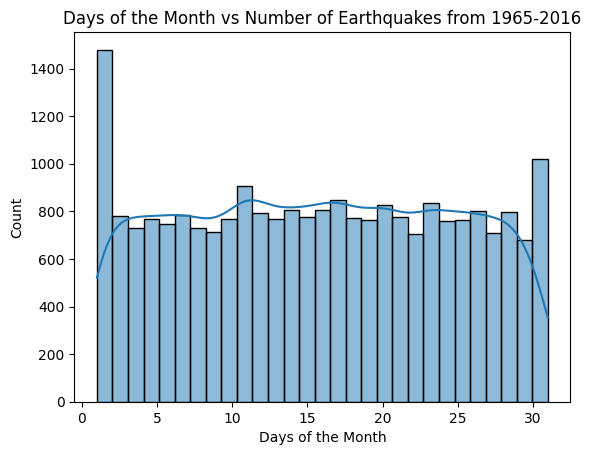

In [36]:
# Plot a distplot to visualize the distribution of earthquakes on different days of the month from year 1965-2016
sns.histplot(day_of_month_earthquakes,kde=True)
plt.xlabel('Days of the Month')
plt.title('Days of the Month vs Number of Earthquakes from 1965-2016')
plt.show()



### **Conclusion**

**The graph shows a relatively even distribution in days of the month,which is what we would expect.**